# Loading packages

In [1]:
!pip install imutils

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from imutils.perspective import four_point_transform
from imutils import contours
import imutils

# Function definition

In [3]:
def adjust_gamma(image, gamma=1): #source : https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [4]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect

In [5]:
def preprocessing_3(image, gamma_value = 2):
    # Step 1: pre-process the image by resizing it, converting it to graycale, blurring it and adjusting the constrast on a custom level
    image = imutils.resize(image, height=1000) #Not more needed
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    gamma = adjust_gamma(blurred, gamma = gamma_value) #build more contrast on the image
    edged = cv2.threshold(gamma, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # Step 2: find contours and build the edge map then we will process the edges to find the right fit for the screen
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None

    # loop over the contours to approximate them and select the largest one having 4 vertices (screen shape)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            displayCnt = approx
            break
    
    # Step 3: extract the LCS screen and transform it with a perspective correction
    if displayCnt is not None:
        warped = four_point_transform(gray, displayCnt.reshape(4, 2))
        output = four_point_transform(image, displayCnt.reshape(4, 2))
        
        #If the method succeeds then we have about 100% pixels that are non zero
        nbpixelcount = cv2.countNonZero(cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)) / (output.shape[0] * output.shape[1])
        if nbpixelcount > 0.6: #The transformation suceeded
            return output
        else: #using another method less precise
            displayCnt = displayCnt.reshape(4, 2).astype(np.float32)
            displayCnt = order_points(displayCnt)
            displayDst = np.array([[0, 0], [400, 0], [400, 100], [0, 100]]).astype(np.float32)

            M = cv2.getPerspectiveTransform(displayCnt, displayDst) #Transformation matrix
            output = cv2.warpPerspective(image, M, (400, 100))
            return output
    else: # return a column if a 4 vertices shape can't be found, this will be discarded by our tests later on
        return np.array([[1], [1], [1]])

In [123]:
def preprocessing_brut(image, gamma_value = 2):
    # Step 1: pre-process the image by resizing it, converting it to graycale, blurring it and adjusting the constrast on a custom level
    image = imutils.resize(image, height=1000) #Not more needed
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    gamma = adjust_gamma(blurred, gamma = gamma_value) #build more contrast on the image
    edged = cv2.threshold(gamma, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # Step 2: find contours and build the edge map then we will process the edges to find the right fit for the screen
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None

    # loop over the contours to approximate them and select the largest one having 4 vertices (screen shape)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            displayCnt = approx
            break
    
    # Step 3: extract the LCS screen and transform it with a perspective correction
    if displayCnt is not None:
        #using another method less precise
            displayCnt = displayCnt.reshape(4, 2).astype(np.float32)
            displayCnt = order_points(displayCnt)
            displayDst = np.array([[0, 0], [400, 0], [400, 100], [0, 100]]).astype(np.float32)

            M = cv2.getPerspectiveTransform(displayCnt, displayDst) #Transformation matrix
            output = cv2.warpPerspective(image, M, (400, 100))
            return output
    else: # return a column if a 4 vertices shape can't be found, this will be discarded by our tests later on
        return np.array([[1], [1], [1]])

source : https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

https://stackoverflow.com/questions/42262198/4-point-persective-transform-failure

# Using the function

## On a single image

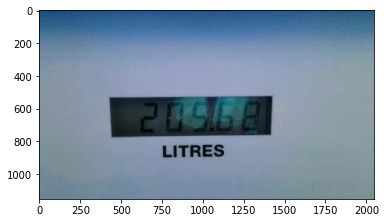

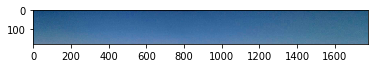

In [89]:
# load the example image
#i = 'data//HQ_digital//3143a8b25a7f6f9ac1b47475d010ea6d113270b8.jpg'

#i = 'data//HQ_digital//f459be06cce486e8199930cfb3ed8c42d2f1a4b8.jpg'
#i = 'data//HQ_digital//f8078b64f04fff2627fa142eb26084a166870bd4.jpg'

#cv2.imread('data/LQ_digital/20af9eb08dd82985ebd33947f51bd9268e1bb20a.jpg')

#image = cv2.imread('data/HQ_digital/659667ef81a9faea100e326ae165535e530785d4.jpg')
#image = cv2.imread('data/LQ_digital/2140017c78aa8e9c5bf87a6f9483d44770327d2e.jpg')
#image = cv2.imread('data/HQ_digital/bf81cd3258241d91ba9e915e8bf309da16a574ed.jpg')

#image = cv2.imread('data/HQ_digital/8ecb0b9d2fba086caf434b7a4864434f9ea0da0e.jpg') #Marche avec .3 au lieu de 2

#image = cv2.imread('data/HQ_digital/67fcfc525568301048c4eeb4554173013daed55a.jpg') #Marche avec .1

image = cv2.imread('data/HQ_digital/dd31a247c313689d77bbf8fbf2bd7dbac8d44333.jpg') #Marche avec .1

plt.figure()
plt.imshow(image)
plt.show()
plt.imshow(preprocessing_3(image, .3))

## On the whole folder for HQ

In [29]:
image_list = ['data//HQ_digital//f459be06cce486e8199930cfb3ed8c42d2f1a4b8.jpg','data//HQ_digital//f655c28f9f983c49d10d0744b6df17b60aef59e9.jpg','data//HQ_digital//f2874f433bb06748b4a583ef35b827ae352ef147.jpg','data//HQ_digital//f8078b64f04fff2627fa142eb26084a166870bd4.jpg','data//HQ_digital//f467271c3de398ffe78268830059c2fd8dc29b90.jpg','data//HQ_digital//f306218639ef34f32df3d50073efd7521f7b3ac1.jpg','data//HQ_digital//fa61c55f5f6118108d5a210875c79e2335bea219.jpg','data//HQ_digital//fbb22d2e929fc4e7cef446edf6306fd807329bea.jpg','data//HQ_digital//fbd02b4f1eac089a9af1a9e0a24e888e3226d6bc.jpg','data//HQ_digital//fc7e8efc0039ff4f010ef9b28783351575e225bd.jpg','data//HQ_digital//fc302f8fddf7e0a77550953f36d6a5148019680e.jpg','data//HQ_digital//fdddffcd1423ea0366eb81802ce1351bccf6dcaa.jpg','data//HQ_digital//fe1dc0a44b58c36fd9215a6d201920deefe7c309.jpg','data//HQ_digital//ffd083a696ac010ca5a9a3cbecdb28a57a167732.jpg','data//HQ_digital//05e5e706f7654e756c1d4dc0740759f9559ab638.jpg','data//HQ_digital//05f3d4b586d92ba18b00dedd6dbe4a163f9ea1c1.jpg','data//HQ_digital//5addbeb17642fd1bedfa36f02aa594601d9a4d7e.jpg','data//HQ_digital//5d86e39532e6eac079395d645962a455678aced9.jpg','data//HQ_digital//5efa991cf18e861feaedf77355a6de1a010cb79b.jpg','data//HQ_digital//6b5d829c02194467ae05ab5c9cc563671814c159.jpg','data//HQ_digital//6be6106d6ca690c46cd575d85294185c86081006.jpg','data//HQ_digital//6d9e01bb68c31e9227beb6b0fd52423f21c16648.jpg','data//HQ_digital//6e698f0b367607f0fa89763a2f1c3e11c42096ad.jpg','data//HQ_digital//7b46efce5cb470220e16da197406c8b21ea2c840.jpg','data//HQ_digital//7c78f916fc9f716f6c7db5095cd690f79b29cd31.jpg','data//HQ_digital//7d5791314bdebcf4d57b8c7f0358abe7cc1003e8.jpg','data//HQ_digital//7df49abdbd72e550b6f37ebb5206ab4e94f4be7d.jpg','data//HQ_digital//7f6c0991090642ce15ee5b79019157f104dcf99d.jpg','data//HQ_digital//08d0cfda33f8ba7f58945e600ae44daa93ed0cda.jpg','data//HQ_digital//8e4f016190f77e5aa58c53509d869e915a0be67b.jpg','data//HQ_digital//8ecb0b9d2fba086caf434b7a4864434f9ea0da0e.jpg','data//HQ_digital//8edb3482301d1a01e52312c33e055b55d2fa9134.jpg','data//HQ_digital//8eeaee0a4748acb92d5fbbccd10c93d120b96986.jpg','data//HQ_digital//9a0c8185141db0f185bed03de473f55c7ef3ba35.jpg','data//HQ_digital//9a36b9a6305e01cb859fce9eb01b9bbfbc4cbbbd.jpg','data//HQ_digital//9b5cac08bb596e68e52fd5f5033f74e00622cfa5.jpg','data//HQ_digital//9b335a61b30d6097ba1417dc56b2f271b86b4be4.jpg','data//HQ_digital//9b53257ee7e2e46b0e2907c5b8aaac4b94712faa.jpg','data//HQ_digital//9e111802446b62b86aeffe911415ad28227caba7.jpg','data//HQ_digital//9f4e2949e665100744dafaaa13c9d436bdd7fff9.jpg','data//HQ_digital//9f7011199d11492f06dd62fc02845952175a8741.jpg','data//HQ_digital//9fbf5baf2483b1c0cb21c8d00cbe6dac038b2ff1.jpg','data//HQ_digital//10edfb73d2b261b00e2f509ec36b05c4d6fab706.jpg','data//HQ_digital//12e7597c51eacba5455793920b73d008db8a63b4.jpg','data//HQ_digital//12eaf64c705f59843fee2458d0f442246077beac.jpg','data//HQ_digital//15c41a2e99339f2698e386e1370ac1471ae430e3.jpg','data//HQ_digital//15ec2ecb8287e6b0e98d20ae5933c0e41012aff0.jpg','data//HQ_digital//18a1f78397b98a02bcbfbe69b390b9c72be1d686.jpg','data//HQ_digital//18f0202e901fb1ed202bc75d68533358e3c8b7e3.jpg','data//HQ_digital//21e25ab0ed146f090ce70a747ce621c60ef263ef.jpg','data//HQ_digital//24bac054e26aff252bc4dc768a43a8d20a82c380.jpg','data//HQ_digital//26f0a94f2cb7b8637e3f5339799d5f4ba1029024.jpg','data//HQ_digital//27f3c33acc8c524f97d752e7577e1c379727855a.jpg','data//HQ_digital//28feeee4d7e52d0ba5d2cee31c8886e57f574319.jpg','data//HQ_digital//29d04b7a38c2d2005f07588f348296f396fe8614.jpg','data//HQ_digital//32de75ac61ffc12b0a3c9a1e797682735c94f0b3.jpg','data//HQ_digital//34bd9ee3b020d9cd5297d6990784719bc68f2f2e.jpg','data//HQ_digital//36a73c74ef0b76639e12488651f587fb06a9baab.jpg','data//HQ_digital//36c8f6a2971fa968f0eb9c75c27136ef2b1bf73f.jpg','data//HQ_digital//39dbdff5337ff8bf555923bf6b4e7918ddf698af.jpg','data//HQ_digital//41b5d9fc07d41287a37339282057a1aff4c7b2ed.jpg','data//HQ_digital//41ba9d95ab7ef9a43bfccfa13f9ffc160f25b8ab.jpg','data//HQ_digital//45d7f253212cb2fbb401aa6193d8b8e4e4420854.jpg','data//HQ_digital//45fec9e34de2083d6e045b7ee99b0780183ab0e9.jpg','data//HQ_digital//46fa7d1747356d68ecae9b59cd6ae8086fd6123f.jpg','data//HQ_digital//48a1a65aa0c10594219c98d6a36ae695e1b0aea5.jpg','data//HQ_digital//49ec32bdf9f7a1f5ddecc606f3cb42a4ae6c44fd.jpg','data//HQ_digital//51bf596a3c477f7944dd6d1fa83da310da375dc0.jpg','data//HQ_digital//57f163278000a53c4199e6cff9e949bef60154f7.jpg','data//HQ_digital//58b18aba0f01c20bc6042525158579785c74eba0.jpg','data//HQ_digital//58dfbdaeab5fda2ceb0e7bafdb240becfafb762a.jpg','data//HQ_digital//60a6920c0470dee667dd218bab542e0528e3ba8f.jpg','data//HQ_digital//60f603ee8cc95cf1125c4f159502f65b85195bef.jpg','data//HQ_digital//62e96bf40409b3b6fd74065ab0bf3ec44f9d0a61.jpg','data//HQ_digital//63a8e6111690bca37052c237047fd85162facf5d.jpg','data//HQ_digital//64c2c2499251eb9ba07f3476d6205a0156773ffc.jpg','data//HQ_digital//67fcfc525568301048c4eeb4554173013daed55a.jpg','data//HQ_digital//73a572dd4369bdb99f5669cb038019160bc63b47.jpg','data//HQ_digital//73bdc1e381510f46aac391bddd99d2dee1f39e8d.jpg','data//HQ_digital//74e0e46b6111bafccb1d01cb684dab0d604a9142.jpg','data//HQ_digital//77aaf9400e8e44b728951ab5604e2eaa6a864dd1.jpg','data//HQ_digital//80f4419eee02f02c34f4b4f65d65b34ad07be278.jpg','data//HQ_digital//81ac47bdd1e225569ed626a723644a00216d8f75.jpg','data//HQ_digital//0086c28630535f9d722eed740f9ce3f8336ec432.jpg','data//HQ_digital//86aefd62c2e164037a5fdfa2feda74801a5da14c.jpg','data//HQ_digital//86f374d068c3526c462b47a55dc2f7cbffe34521.jpg','data//HQ_digital//87e827d58b36c7921568b270eae938e677c97207.jpg','data//HQ_digital//94d7dd836ea0c1b8f4fdf7dac0779e009bd2de7c.jpg','data//HQ_digital//97fbf9288a53ee809eb4538b507b1b8c01b17be5.jpg','data//HQ_digital//98ec95acaf26bde374a5301009c0fe7c09e447ac.jpg','data//HQ_digital//129bb38115a3cf224bdf9a593e2df0465db79bc6.jpg','data//HQ_digital//169ee15bb3b1036bee1012ec12c91048939b1589.jpg','data//HQ_digital//184bad9043c572a63c3e2f838e79955faf946181.jpg','data//HQ_digital//191fdfd5dbe6f3c98f8c177128349077b1e4c876.jpg','data//HQ_digital//0249b3ed6a5442489f764e48177e28422e48296a.jpg','data//HQ_digital//494c6fda6eace52cecf37de39c5921517739ab58.jpg','data//HQ_digital//503c6f058305af8803290cfd7b101f61060ede87.jpg','data//HQ_digital//530cd0787c68b42d9a0c2d054b28bdddc37b1175.jpg','data//HQ_digital//0688de8a02d78ef6fc31ee7aa625eb1a7dc3ba4a.jpg','data//HQ_digital//768ffa2daba12461bc698a2b740ecbbfb15fce8c.jpg','data//HQ_digital//947ed0d788292140ef2a23326969d962d423575e.jpg','data//HQ_digital//957d8fe28fed4ca5f8b2aab0a4ff3032ca631165.jpg','data//HQ_digital//1755d81d0bbd4be27d0389b6edf416ff50621d4f.jpg','data//HQ_digital//2498d375b9d31b142841b57a4ac3983e7a698075.jpg','data//HQ_digital//3143a8b25a7f6f9ac1b47475d010ea6d113270b8.jpg','data//HQ_digital//3783acb95a917cf46cd7dc0fdcf9466cc98707bb.jpg','data//HQ_digital//4534e267bea350e8afdfff3e9c4d0933933b0429.jpg','data//HQ_digital//4556bd987b4448bf6a45adf2fb9b40d495d1f00d.jpg','data//HQ_digital//5108b091a7f6a6364f7f125cead992f55fafb8ed.jpg','data//HQ_digital//5232b54dc19f64026dde07b3d3f3b7b868162352.jpg','data//HQ_digital//7910fdcf50e2e8a471e13056eec64befa8a94140.jpg','data//HQ_digital//9254cdb3e6d79badf7aeed6973383edaaaaa7e64.jpg','data//HQ_digital//9879e8fcac36d3a82bea304b0af56bde5533f5f1.jpg','data//HQ_digital//16059ed087ceb8a0d664934a78c414349bf9ac93.jpg','data//HQ_digital//28664c8bffb7bec48411563f3c0db7e5f118889b.jpg','data//HQ_digital//30131c888cef3e66e4cb4f29ee45c43c8b24aeaa.jpg','data//HQ_digital//48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg','data//HQ_digital//55879a955e5b20ea30ead7c5b3557287b335c632.jpg','data//HQ_digital//64497aa7f4d0ec03260d50917487bf7e0dad8631.jpg','data//HQ_digital//85734ff0041e6244f29ffcfbe2c89d8c580162dc.jpg','data//HQ_digital//260693f35709a7fe26304978d77ab9ccc45fa5ad.jpg','data//HQ_digital//474494db28922d7e400d7b24541695bcb6366532.jpg','data//HQ_digital//631887ed74c7390a6e2c81d5c11ac529b40cac24.jpg','data//HQ_digital//647517ae17cb333fe4187bdaec6db1e919c52896.jpg','data//HQ_digital//659667ef81a9faea100e326ae165535e530785d4.jpg','data//HQ_digital//840502a0ad0ee55ef41b7a051cc86d9471559cb1.jpg','data//HQ_digital//852980ab54fe5cf1039940b0e6ac33a47172a12f.jpg','data//HQ_digital//1046212bf9fd73fcd343e2f80886e92ebe4f7673.jpg','data//HQ_digital//4155206a4bc1633ddfb2f0fd907dfd01d2e1616e.jpg','data//HQ_digital//4406201aab58cec6990ce4738eec3f353ada3c0f.jpg','data//HQ_digital//12662593fe501b98e441b948ad553a46cc1944cd.jpg','data//HQ_digital//92230131b7174318da8b76b80884ebf17f9ea6f6.jpg','data//HQ_digital//165679858cfc4cd754e71a14d0381bc94a521cba.jpg','data//HQ_digital//500754878cb758552f525280c872dc565b3de8b5.jpg','data//HQ_digital//846136278e66e5431f21403ca750168fd825930a.jpg','data//HQ_digital//81200578963bee698c6c450dfb448255f0b991af.jpg','data//HQ_digital//373864709100c8c0b8f3e6c3722ff9453747b889.jpg','data//HQ_digital//565655306167c014f879797a2ee651ad590f1157.jpg','data//HQ_digital//2236648840225d976d1feb6155c9de07b129f403.jpg','data//HQ_digital//a0fcee07eb3fbe5145ec497d42a918fbc615fd4e.jpg','data//HQ_digital//a6bd371130fec0f12d7b2a32865ddae3e026aa37.jpg','data//HQ_digital//a92e0e57271054308e87d3fd64530bd812c43978.jpg','data//HQ_digital//a3169ca6db33dda2b32c96f5063117e2ee3eb2c0.jpg','data//HQ_digital//a7587241454eeec7fa380250102423a7ff64c22b.jpg','data//HQ_digital//aaa54960feb69aa9be5bb088ad9dbf0a6d4cee2d.jpg','data//HQ_digital//ac74fcbbaced723cd4ba98fd7fab764a665783ec.jpg','data//HQ_digital//ad09efeb3fb287283c6674797b9214313d12b5f1.jpg','data//HQ_digital//ad303bb8b900d6002a618c9edb2691e4927986d8.jpg','data//HQ_digital//ae7c13f09ce55a6ebb4eab0819b5340f960e89f1.jpg','data//HQ_digital//aee88596159ace71523271065199866d5ed89dad.jpg','data//HQ_digital//afc914e1bdf29f16b78de8afd3dd3739a55dc914.jpg','data//HQ_digital//b2b721636f4ba3ef7cd4f2e2eec3730116470f58.jpg','data//HQ_digital//b3a9e5dcdca2c89d0e0ccc9aab1d74f74ddb9cd6.jpg','data//HQ_digital//b5d5e0eff5f4408e101561c89f0172212a6d2216.jpg','data//HQ_digital//b7f78a8f28674b7700c7c8f0c1e949cd6eab5f42.jpg','data//HQ_digital//b77a9c3bdaf91f0fcce9ca05f598c34139a11205.jpg','data//HQ_digital//b772d011f189cc97e88de5d114a0821941435fd4.jpg','data//HQ_digital//b802e264b4be4f3ea85671ef53da4d39097a2937.jpg','data//HQ_digital//b0960a1248959ec24e6a7241e8c6c6d343c1141d.jpg','data//HQ_digital//b4277e42d2cce05adde28e436ecc141c4733ab45.jpg','data//HQ_digital//b746312f413f1373779b00b82d9c83c0e3d881b2.jpg','data//HQ_digital//b709749645b5c905d731a7f3725433b7c0360526.jpg','data//HQ_digital//b1195235570b5ee9f11ba8adb64e165b8d81e6d0.jpg','data//HQ_digital//b9459761282e4785af2ece0ad86a9fcd05047bfd.jpg','data//HQ_digital//bd2e1293ba838ca0fb9baf0d4a8aaa7cfda007dd.jpg','data//HQ_digital//bdbf41a1d93043386f690c2ab077b1bff5bc023f.jpg','data//HQ_digital//beb7c3ddd59f77b342ab1d4016d11562f8543de6.jpg','data//HQ_digital//bf52fb9d9ca985341979a2b9db06838614f306b5.jpg','data//HQ_digital//bf81cd3258241d91ba9e915e8bf309da16a574ed.jpg','data//HQ_digital//bf587a4df84cc4dd291e9c64b1c0e5a0d198580c.jpg','data//HQ_digital//c1db6c89fb26a051f71726f7df032e43de6046bc.jpg','data//HQ_digital//c2d2ca4a41d723ee42c407d1fdc86a542b597dc0.jpg','data//HQ_digital//c5afb8d3970a23a361c3f8a1e54400d5b0d07c89.jpg','data//HQ_digital//c6b10b24c45ce1cbe505f6130b14c503810ee3d6.jpg','data//HQ_digital//c18b6f8b996ee88e387824a41e123e9e3e56d348.jpg','data//HQ_digital//c56c79a6eb6df9942c4922b5112e7855d79b4867.jpg','data//HQ_digital//c203beb685cec15caa6a25122daed0b28df3b951.jpg','data//HQ_digital//c0313de737369b43bb8d6855517e4980630c89bd.jpg','data//HQ_digital//c836ea17748e562c99f93edc51f2b900664ec37d.jpg','data//HQ_digital//c1119af716de4f4954efb087092a49ee3b48be13.jpg','data//HQ_digital//c6050c9162ec2310f81dea88715d9f0af4f98942.jpg','data//HQ_digital//c61272eefb1800353952a64d8232b2fdf3a26e52.jpg','data//HQ_digital//c69919d412947c420a8150017bcb05cda8ab7fb7.jpg','data//HQ_digital//caed5ebb6fc271d447c2f286dab64583e64c3324.jpg','data//HQ_digital//caf2e1f69e943deb7a05a4b1f08de37651b9498b.jpg','data//HQ_digital//cc3f2c7a152b1353e4d0149ea4516bed71c781df.jpg','data//HQ_digital//cc4bf7bc265a045746f6a2ac3c77c6a498712307.jpg','data//HQ_digital//cc9acb43543022d0e9ba0af8e059f92a602ba80f.jpg','data//HQ_digital//cd4d249fd27369f927124e67151b8d97e4bdfdd4.jpg','data//HQ_digital//cf9e98f7f7793bc13d41d24a7fce6ef600a57fa4.jpg','data//HQ_digital//d4b26d2b599dbad8acd3db7ce0f7242758b05907.jpg','data//HQ_digital//d4d80b48e9a9cc80bdcfa4cdadf29951a18df346.jpg','data//HQ_digital//d4e4850433c86506a1e0712a3fcf639dba393c79.jpg','data//HQ_digital//d0183d179d58dd8157283feb50a7b2bd53b24005.jpg','data//HQ_digital//d350bed5855bb0233e9f539da24ab4d9fd25eadf.jpg','data//HQ_digital//d795e6592de9c1c5187a86769b8c5d7444cbaefd.jpg','data//HQ_digital//dd6b9a76ce131643252f4738bf1ec759809fc4b5.jpg','data//HQ_digital//dd31a247c313689d77bbf8fbf2bd7dbac8d44333.jpg','data//HQ_digital//dea0071da808c456b52e9ae7c681ce12d522ec38.jpg','data//HQ_digital//e1aede3b8be7b86dbacf12494d7fb737f614e1df.jpg','data//HQ_digital//e1d0c7cffa534df014e9a2970b1b29171f8a8a90.jpg','data//HQ_digital//e6bf1df203b043c813d09f9db881595406920725.jpg','data//HQ_digital//e8cf4d4a50b7b5502cad2d1d36655f3734551428.jpg','data//HQ_digital//e47f55e29fb263bcdda378a8fc9fcc14cb532653.jpg','data//HQ_digital//e72a9402841f1fd6a2c3c9f27a25d405640ce194.jpg','data//HQ_digital//e091c458e962655ceff9bff8ff56961d8ce23b99.jpg','data//HQ_digital//e834fadd3461bb593a7d2d72885f8d2319480b87.jpg','data//HQ_digital//e023858ed388731bbccbbc2d6a64983b145b0b4a.jpg','data//HQ_digital//e104664ba1792dde641d87cd5d95f1df06786140.jpg','data//HQ_digital//e452881a7b82c7b224e38b754424da1f3b96060d.jpg','data//HQ_digital//ea505d33dc581c054d6ab218048536b9e5b05fe4.jpg','data//HQ_digital//ebbeb1b4a007e7d5a4f62c2b504484c09fb43dde.jpg','data//HQ_digital//ed19955cfa901c23e20ba492411e34906586436e.jpg','data//HQ_digital//f1cbc378299894f7f09e6d3aea25b0f962e9af8a.jpg','data//HQ_digital//f4c377be5defcba29c7f722b718a7319988e6add.jpg','data//HQ_digital//f9b1f447c64e60597eef190ab328460c77a17bd0.jpg','data//HQ_digital//f27af009385bf56b693dd96ca50bfdc93b8a945a.jpg','data//HQ_digital//f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg']

image_list


['data//HQ_digital//f459be06cce486e8199930cfb3ed8c42d2f1a4b8.jpg',
 'data//HQ_digital//f655c28f9f983c49d10d0744b6df17b60aef59e9.jpg',
 'data//HQ_digital//f2874f433bb06748b4a583ef35b827ae352ef147.jpg',
 'data//HQ_digital//f8078b64f04fff2627fa142eb26084a166870bd4.jpg',
 'data//HQ_digital//f467271c3de398ffe78268830059c2fd8dc29b90.jpg',
 'data//HQ_digital//f306218639ef34f32df3d50073efd7521f7b3ac1.jpg',
 'data//HQ_digital//fa61c55f5f6118108d5a210875c79e2335bea219.jpg',
 'data//HQ_digital//fbb22d2e929fc4e7cef446edf6306fd807329bea.jpg',
 'data//HQ_digital//fbd02b4f1eac089a9af1a9e0a24e888e3226d6bc.jpg',
 'data//HQ_digital//fc7e8efc0039ff4f010ef9b28783351575e225bd.jpg',
 'data//HQ_digital//fc302f8fddf7e0a77550953f36d6a5148019680e.jpg',
 'data//HQ_digital//fdddffcd1423ea0366eb81802ce1351bccf6dcaa.jpg',
 'data//HQ_digital//fe1dc0a44b58c36fd9215a6d201920deefe7c309.jpg',
 'data//HQ_digital//ffd083a696ac010ca5a9a3cbecdb28a57a167732.jpg',
 'data//HQ_digital//05e5e706f7654e756c1d4dc0740759f9559ab638.j

In [174]:
# load the example image
for img in image_list:
    image = cv2.imread(img)
    #plt.figure()
    #plt.imshow(image)
    #plt.show()
    #preprocessing_2(image, 2.5)
    
    
    if( (preprocessing_3(image, 2).shape[1] > 2*preprocessing_3(image, 2).shape[0]) & (preprocessing_3(image, 2).shape[0] * preprocessing_3(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 2))
        print("step 1")
    elif ((preprocessing_3(image, 0.3).shape[1] > 2*preprocessing_3(image, 0.3).shape[0])& (preprocessing_3(image, .3).shape[0] * preprocessing_3(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 0.3))
        print("step 2")
    elif ((preprocessing_3(image, 0.7).shape[1] > 2*preprocessing_3(image, 0.7).shape[0])& (preprocessing_3(image, .7).shape[0] * preprocessing_3(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 0.7))
        print("step 3")
    elif ((preprocessing_3(image, 0.1).shape[1] > 2*preprocessing_3(image, 0.1).shape[0])& (preprocessing_3(image, 0.1).shape[0] * preprocessing_3(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 0.1))
        print("step 4")
    else:
        print("------------------------------------------------------- error image de merde - " + img)

step 1
step 1
step 2
step 1
step 1
step 3
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
------------------------------------------------------- error image de merde - data//HQ_digital//05f3d4b586d92ba18b00dedd6dbe4a163f9ea1c1.jpg
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 4
step 1
step 1
step 1
step 1
step 1
step 4
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 3
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
------------------------------------------------------- error image de merde - data//HQ_digital//67fcfc525568301048c4eeb4554173013daed55a.jpg
step 1
step 1
step 2
------------------------------------------------------- error image de merde - data//HQ_digital//77aaf9400e8e44b728951ab5604e2eaa6a864dd1.jpg
step 2
step 1
step 1
step 1


135 / 218 -> 62% accuracy

190 / 218 -> 87% accuracy using method 2 without canny

198 / 218 -> 91% accuracy with the conditions and gamma ameliorations

200 / 218 --> 92% accuracy with the size condition -- 211/218 ne sont pas déclarées comme intraitables

10 wrong detections and 7 fails

201 / 218 -> 92.2 %

205 / 218 -> 94.0 %
    --> 6 detected as wrong
    --> 7 wrong output

# Using the function for LQ

## Using on the whole LQ_digital dataset

In [31]:
LQ_image_list = ['data//LQ_digital//0ed563ebf44130ed276f07324008b28d88d5f36c.jpg', 'data//LQ_digital//0f1d8e1da3fdf5cfcacb4a824e4e77f7bd72f52e.jpg', 'data//LQ_digital//0f2e8ac5cc3136234ecb41160eab0893f817910b.jpg', 'data//LQ_digital//0f05dc10feb8e544d743e4bca1aad6b6cf0810bf.jpg', 'data//LQ_digital//0f5e7f6d8632b5ea1d6bb3bee11ab64799f08d7c.jpg', 'data//LQ_digital//0f8e6744ed8b322bbeb54599b309ecf2e0de4945.jpg', 'data//LQ_digital//0f13aa7539ca0dd52844366c3ec25a569688a033.jpg', 'data//LQ_digital//0f221729e0296f6671c818fec857b4a828f23274.jpg', 'data//LQ_digital//0fa5c05eae31f738f18880d00c3a20bc076cb495.jpg', 'data//LQ_digital//01acf34e2e7d2d9807fbbfb5ba243c5977e6c9e9.jpg', 'data//LQ_digital//01c2f9d135b21a9139f7cbecc26dd4feff1627d1.jpg', 'data//LQ_digital//01d50cc49f489cbbe66b7c482b1b07fe97b42c5c.jpg', 'data//LQ_digital//1a5bd719ef497ccce3884bceeff5de2a3da0a091.jpg', 'data//LQ_digital//1a9cadce49b5cea9a08a235be090b61d29158d9d.jpg', 'data//LQ_digital//1a97f3c9c829bb011c69db95d64b52dce26bfa64.jpg', 'data//LQ_digital//1a62597c11b9158d1ddac1baf78881031051ff62.jpg', 'data//LQ_digital//1ab9a5d0784ed58025fdf4c05bb7dcc9bdd82d1c.jpg', 'data//LQ_digital//1adcd452c57a2ded88b5b23fc8dc2a07ea6a9baf.jpg', 'data//LQ_digital//1b5c6804e4d643de9cdae321ceeb9b5d0231ae07.jpg', 'data//LQ_digital//1b6e87e09884270ef8d5ca8c17a4d530b339d447.jpg', 'data//LQ_digital//1b23bde5f77d2cfd61390ea9fe4e344a8d9c6df4.jpg', 'data//LQ_digital//1b053ba3945609e0a8850a5a864e74838e572adf.jpg', 'data//LQ_digital//1b550b3b8550f70e0532e7f84c18b27a8711367d.jpg', 'data//LQ_digital//1b4168c6e014d9588802c70e74cde6511c012454.jpg', 'data//LQ_digital//1b6948b086f001d12a153572606f78744c006c24.jpg', 'data//LQ_digital//1ba1e0e5b63d9d9451bf18b4a934ba2774ed6ddf.jpg', 'data//LQ_digital//1bac4cf72219617d39d5db4ad44bed1baaa30df3.jpg', 'data//LQ_digital//1bba22daf4e03295d6b52d6d3aa7a0dc019ab8c0.jpg', 'data//LQ_digital//1bc770862ea5d73bfa42ea937b13dbfa52190852.jpg', 'data//LQ_digital//1bfcede437f42a5d1aabc734dbe952f0ca0a95b1.jpg', 'data//LQ_digital//1c0cf63b3e24405bd23d2d0bfe5a8452a1f994c8.jpg', 'data//LQ_digital//1c1c718f7dd549b0202edaf3bf6147ef18025cc4.jpg', 'data//LQ_digital//1c3a1695baa8639a34118790f2490a2ff20e4b6d.jpg', 'data//LQ_digital//1c6dd700ed4939e027441264564efcb05f624de8.jpg', 'data//LQ_digital//1c7e93182fd59d94c041fca150618df194b54f87.jpg', 'data//LQ_digital//1c9aa921313f8b3b8dfde6130c91d9de4391570b.jpg', 'data//LQ_digital//1c2382dbea98c188687221510c43e9fd4e29afcb.jpg', 'data//LQ_digital//1c5469b7d54884a85616cc122f72dbc8cf769576.jpg', 'data//LQ_digital//1c9408957a827a1bce36d9057d8a075e7c0b706f.jpg', 'data//LQ_digital//1ca1a48fd14bca5653e98309f50d6476c4cd15ad.jpg', 'data//LQ_digital//1cde9ccb159cb0b09af8cb004113d3f8be681c95.jpg', 'data//LQ_digital//1ce8e986b4f49fa00ebf96b3e64ea226326e87af.jpg', 'data//LQ_digital//1d2a55aafd98aae0740223c48b23ad7cfbdfa7c0.jpg', 'data//LQ_digital//1d6dc7383008ed8d2c0f303b53ba39ee0c198419.jpg', 'data//LQ_digital//1d335098977d3daf11051b28dea187de9e2c96d9.jpg', 'data//LQ_digital//1da137a462dcfaffb1080748779a8229d978524a.jpg', 'data//LQ_digital//1dafcfe3396e0408ca82061eef6a43f9f732fb91.jpg', 'data//LQ_digital//1dd0d6931af2dd9eb5c94f9b41cd6fd0619067c5.jpg', 'data//LQ_digital//1df8a59b35f1e69a901a950b18c00300a6eb7685.jpg', 'data//LQ_digital//1df11a1003530da7f49e7dec9b48e9aad214683d.jpg', 'data//LQ_digital//1df65db52c4d483cb50592e2b1501f4fb29ac721.jpg', 'data//LQ_digital//1e0ec6a309e96e512794dc6b1d01fefb98b5ff23.jpg', 'data//LQ_digital//1e4a192290e9550130bcff53f5903dc9d5c779f4.jpg', 'data//LQ_digital//1e9dc4905d93ca07b0f4108a347ce874c844ec45.jpg', 'data//LQ_digital//1e12adab9c1cf9fc2767b5570ea09e16bcbd052d.jpg', 'data//LQ_digital//1e97d030260bba497fb585b795c9afbf77623b68.jpg', 'data//LQ_digital//1e208b90dd3effa0b11ab792dc605205fc497456.jpg', 'data//LQ_digital//1e447e6ac24a0dce1790431e58652c2205156900.jpg', 'data//LQ_digital//1e7448a9a6ae59e6b93feece8f0fdbe522732b6d.jpg', 'data//LQ_digital//1eaad91b157095fdf3b970673ca5cc2a23ca2f48.jpg', 'data//LQ_digital//1ecb08b090b56913c4edf42c515d6933ecb7ec3e.jpg', 'data//LQ_digital//1ed5a9efd837933f8f316c8de9a13e02e5ed92cb.jpg', 'data//LQ_digital//1eda78f2a5c54b517e53c1f71f0acddbc072246f.jpg', 'data//LQ_digital//1f09f9f0469274fe36d24ecd41ae6b228ad64159.jpg', 'data//LQ_digital//1f12e3a5efa64f0f6a191c805ea4108bdfec656a.jpg', 'data//LQ_digital//1f0988d745d9e1c81e58e6e62b9cf70c8f500e55.jpg', 'data//LQ_digital//1faadcd60711bfa7aed065e53cf8b61c95aea34b.jpg', 'data//LQ_digital//1fbf0c07f81460ac53b80511fb55c06d32a3850c.jpg', 'data//LQ_digital//1fe0c3f52881dbe377454659862b7f1118f01d58.jpg', 'data//LQ_digital//1ff9eef553663acb92add0027644929822be7af9.jpg', 'data//LQ_digital//1ff55752b970aa4fe70abba28cab7df3da7d772a.jpg', 'data//LQ_digital//02b1c61670139b5eb2486f4032dc8b3466702200.jpg', 'data//LQ_digital//02b9e81c1f5bdb956f7a5c85f8aa964e02947c97.jpg', 'data//LQ_digital//02ef105d87ae6ac485c22bd296aab79fbafae665.jpg', 'data//LQ_digital//02fa089c3f84dede3da23025f669d3066ee55b1c.jpg', 'data//LQ_digital//003f850dd53366ca94bf48a6d47025d2e8241723.jpg', 'data//LQ_digital//03b7bead12c27d365a5d203b51f08c6f56e7969d.jpg', 'data//LQ_digital//03b92e70372b7620e2a2f844b7789f729783fcd8.jpg', 'data//LQ_digital//03c573f7562841a5d5de3e237c215c36b8e44e23.jpg', 'data//LQ_digital//04ca2e54c4e2e994dc7227f4c650af003165b924.jpg', 'data//LQ_digital//04f00f08ab175a6b86015b84940ef237946da1b2.jpg', 'data//LQ_digital//04fa85dc70bb282a0a6f7e5f6226a46b47bd939f.jpg', 'data//LQ_digital//04ffa7c87c0412f538dacdabfac0b150b3a9ba0b.jpg', 'data//LQ_digital//005b1a6cf0d2484b562bd8c5ab0353e58dbee9d1.jpg', 'data//LQ_digital//05b575b71a82163a7bdb082904a7d553f32f66a6.jpg', 'data//LQ_digital//05c9f1f992327506b286f8bbd6178656e258e8e7.jpg', 'data//LQ_digital//06bddfc37fdcbbb68f00f76b9b619d22035bd286.jpg', 'data//LQ_digital//06cc65bcc6bdbed5af3afcd6c08dbca5475fff76.jpg', 'data//LQ_digital//06cec77f0f984cd7776c059a2aca2e4105071af7.jpg', 'data//LQ_digital//06dc61e60a2a6c650a61dfed2e3b27df7b155ff9.jpg', 'data//LQ_digital//06e69ca9bf59312e2041f87dc67925c4a0f08430.jpg', 'data//LQ_digital//06f8b8924a15bbc86c9b0779827f6e559c4821cb.jpg', 'data//LQ_digital//06fc841b2a022883c8184ed2fa314b9053c5a9da.jpg', 'data//LQ_digital//06ff061c463443253a9b6fa945a9ee9fd2f9953b.jpg', 'data//LQ_digital//07e86ec693974fbf776cf1762f386da5b54a0eba.jpg', 'data//LQ_digital//07f55c83fc6c59a31cfa3f7deeb249f7193c89a9.jpg', 'data//LQ_digital//08ac3f405d34b1f5454846398e3686f111dba44b.jpg', 'data//LQ_digital//08bdb453bd3b84eaf0340b143ada94fc997a37f3.jpg', 'data//LQ_digital//08ca689e9648f2874fc69a48006777bfb8e7992b.jpg', 'data//LQ_digital//08cd65db0705105a6d0b52b47d1f36b041487581.jpg', 'data//LQ_digital//08d21828339e1a6adcd892ef2f0d0866083c51bf.jpg', 'data//LQ_digital//08e5c29addcf21a37718722500e74e07a387834d.jpg', 'data//LQ_digital//08f9e4f505697b3cad80a26ba645d80b7cb28562.jpg', 'data//LQ_digital//09ae97265223b688b67803c3f471e528c9df6939.jpg', 'data//LQ_digital//09b80a02730dee832009b731784630566b874980.jpg', 'data//LQ_digital//09b283c81a4bd3a19d8329bda8f7d8e301739558.jpg', 'data//LQ_digital//09c8254fe0f51a8b66c9a1fee53c0d22c5d5c0e7.jpg', 'data//LQ_digital//09d66d47aa62a60d35fcb38a79cc0694c47962f9.jpg', 'data//LQ_digital//09fda954ae2a797eaa9cc6ee8b66884b158f8bba.jpg', 'data//LQ_digital//10a8d9c7d99baabd9aa4aab95255618f35ea0738.jpg', 'data//LQ_digital//10cea9f9a4ceec207081760b0d8a81efe91b5802.jpg', 'data//LQ_digital//10f79fbe4274bd278c3f10f2d5f63a302d9cee0c.jpg', 'data//LQ_digital//11bb381f0b607b481d7e7c642285fc06b0f46042.jpg', 'data//LQ_digital//12a565a382f82ae33fabe183c53a1ac271f2390e.jpg', 'data//LQ_digital//12be8b5dc8c1b08ec579940710ddd6e1443b512b.jpg', 'data//LQ_digital//12d839a3d2353283c6943a10fc41506f77f8cba3.jpg', 'data//LQ_digital//12e168d35925db85c94cf9b95b7683f071d6ea61.jpg', 'data//LQ_digital//12f3b49b495578fc3faae1bb7dc9905affd92ed4.jpg', 'data//LQ_digital//12f4ac5cb886c93c80a23dd0835ed3f4053106bb.jpg', 'data//LQ_digital//13a852eaf64b536a4e0e41e9609cc92ec0fedead.jpg', 'data//LQ_digital//13ca152e604837be2bdc660df2877bf415bb193b.jpg', 'data//LQ_digital//13f8f72a9743232633f390ee4a28a7703bbe3a94.jpg', 'data//LQ_digital//13f61c49ac032d3ddcfdaf402006223741451e81.jpg', 'data//LQ_digital//13f4074520883462266b0eab3f13246c6aa07aa8.jpg', 'data//LQ_digital//14a5f2f319d5141d645cb652ee80f262c87b21e3.jpg', 'data//LQ_digital//14a85ce20ee84f9c83b67f99e7eed22c772fabb8.jpg', 'data//LQ_digital//14c6d59dd775794c094ac927e0d5545c69721bd4.jpg', 'data//LQ_digital//14d0c2db1882288556b7c4aa8676da86df501bc4.jpg', 'data//LQ_digital//14d41830fc7e0225f9a3c5af110c849c76c5c6f6.jpg', 'data//LQ_digital//15b3ed794e270a24f01620586fed17f53344c54e.jpg', 'data//LQ_digital//15cda7bf36a8d8b8de543ed1ee5749dc356dbee2.jpg', 'data//LQ_digital//16ddf64847f3343c0b741858e8f499cf13e8efbf.jpg', 'data//LQ_digital//16ece67657805562e03617b7a57a1eb43ed72903.jpg', 'data//LQ_digital//017aaf5f05f9cb27557ba2b10121fdd7b910a406.jpg', 'data//LQ_digital//17b2bec78ebbbb1a239734a48c54e13481cf937f.jpg', 'data//LQ_digital//17bf0739bf830b20ef259d18788e74d4209d922b.jpg', 'data//LQ_digital//17e434e3e3f1c502cf3568db2c1c08613512ac09.jpg', 'data//LQ_digital//17ef620d20013eda5358b375de69b79af632d8b6.jpg', 'data//LQ_digital//17f734894d183af2a3326a334feb4f706b0f5c21.jpg', 'data//LQ_digital//18d547cc3c8a4ae9355b31763aecb9ca1d6e903f.jpg', 'data//LQ_digital//19ad5cc9a329660869d5de0aa92d4ca74d54468a.jpg', 'data//LQ_digital//19de5c1e7403dddcc58fe6d3adc4ed3759617a81.jpg', 'data//LQ_digital//19ecec1cc7fdc8bb75a33deffa12c07c539a0856.jpg', 'data//LQ_digital//20af9eb08dd82985ebd33947f51bd9268e1bb20a.jpg', 'data//LQ_digital//20eeb18a1f2afe9ea0e09bfc4e1abfe6010615ea.jpg', 'data//LQ_digital//21d38316dc24cd67c7f1dc715160f4b736052d86.jpg', 'data//LQ_digital//21dd32102ff4b794e01d8e6a5429103116f1dd3e.jpg', 'data//LQ_digital//21fde4cdb701b5e8bdaa222921a44a0de8567a8a.jpg', 'data//LQ_digital//22b09cbc2038cc916db72a82ad0a9d95086534eb.jpg', 'data//LQ_digital//22c83e3cc927a7d50dcaea9a12454a550dcf3812.jpg', 'data//LQ_digital//22e243756e856aa20fe305669988b86fa84cda93.jpg', 'data//LQ_digital//23c7d2ed30476359326e1a624be570afb98e2699.jpg', 'data//LQ_digital//23ce057728a29ccbe49660511d4dec4f20203f0e.jpg', 'data//LQ_digital//028db92ffbe41bbdc0c7071239e1d579eb3e0792.jpg', 'data//LQ_digital//031c88432659fb807e3e10ace7f1b9f00911ef01.jpg', 'data//LQ_digital//038a14bfbc6d31090df2e91417c145c81d5539bc.jpg', 'data//LQ_digital//040d05439b08fb8f4af453bd64e43ea47fb829a0.jpg', 'data//LQ_digital//040fe5eaa0e1767fcc14a08aa1fd32334bb480a4.jpg', 'data//LQ_digital//046b00fd9cdede7779708461dbe4999154684f7b.jpg', 'data//LQ_digital//0049f5e5a1de1b35fd58c707f41a6e25c0472902.jpg', 'data//LQ_digital//050c973ad7a3e762355e69bf2029eb54446e16d1.jpg', 'data//LQ_digital//054b18716508c5e377f4c83e2c8778ad07dd73e5.jpg', 'data//LQ_digital//061d1c5456e46a8f8ad6dffa788647d612d8272f.jpg', 'data//LQ_digital//066b77046643b58768679339bd153783989477b2.jpg', 'data//LQ_digital//073e480c427c829d8251712e2cdf9100e1a0f5e1.jpg', 'data//LQ_digital//074ae910537e2603655a85c49c83e4c0559152f1.jpg', 'data//LQ_digital//075e579783297a4fab0b866af8d3ae13b6873e39.jpg', 'data//LQ_digital//076a28ab498dac374d9c47bab758137b87429fc4.jpg', 'data//LQ_digital//076e55732f032a05048d37d30dae1dba0e7e9408.jpg', 'data//LQ_digital//077ab6467461c606127938624b27b0604c6df604.jpg', 'data//LQ_digital//077c03fd2d07356e8509c6b626f435d197887956.jpg', 'data//LQ_digital//080dcd330da13037add163e17c91550d2e946b55.jpg', 'data//LQ_digital//082cb44c0f16c7883ce69d3a9b4db6bcd61dce67.jpg', 'data//LQ_digital//083b86985e38e8b80e0b8278b552bbf98ef6d294.jpg', 'data//LQ_digital//085d40a4f08f0cff0b9483e15bea7f58fde04ed5.jpg', 'data//LQ_digital//087d4001282bad3f09c78b554e0d145699445d93.jpg', 'data//LQ_digital//094a2ccd334b1f57a1a7de700e88f2196cb0aa01.jpg', 'data//LQ_digital//094d20605f89748033c33443e0fa2bdba4c127ac.jpg', 'data//LQ_digital//096f86d026f75e1a1fd58997f8880bc3d04130db.jpg', 'data//LQ_digital//0098fde1754c51028bb4785e9eb5ef39519c1e16.jpg', 'data//LQ_digital//102bb04f124472ff6440f44d66e86c7fb4eaa66d.jpg', 'data//LQ_digital//0103cfe2bc953da1a4d0a24b0d1870c4cc708eea.jpg', 'data//LQ_digital//108d8ccc2dc0fffe6f01dce3415b4aba8147cf73.jpg', 'data//LQ_digital//110fe91175bcab48f1aa01aee68a9554712f55ec.jpg', 'data//LQ_digital//112dabc2b291a2000b8b994fccddcdf91636eb7a.jpg', 'data//LQ_digital//122fed9c1dd5a2f1a1ec0b8c076d6ac2a520b405.jpg', 'data//LQ_digital//132d365ccede6d01b745b04ce22ed172790db50a.jpg', 'data//LQ_digital//138caf893569777cd3204df678e352a9c457dede.jpg', 'data//LQ_digital//141e4edbf365a523d198c866830f6d2302d7e0a8.jpg', 'data//LQ_digital//144a43741b9b6f7301e4b9c0251593b920f4150d.jpg', 'data//LQ_digital//146c1ee65111c9dc26a4d67d3990c0a723071274.jpg', 'data//LQ_digital//147e5e634eccda8c75bb50b539ec8e768bc95b43.jpg', 'data//LQ_digital//152b2d43d5631e909112db8a9e54b3dbb6f66e1f.jpg', 'data//LQ_digital//152b5076c320a236b29fd15a00ef58c78b312fa7.jpg', 'data//LQ_digital//152f49bbd8316887258b25a2438a6502b8f019d7.jpg', 'data//LQ_digital//164e4f71b6406ef8128c99bcec3488e002857fe5.jpg', 'data//LQ_digital//0167a048f5484d9c50d0078a0b7d1060690775b5.jpg', 'data//LQ_digital//170cc2c99908a5d4c18f309dfe244167e6416318.jpg', 'data//LQ_digital//175f51edbe55fe7781d49f06fcaafe22ea578901.jpg', 'data//LQ_digital//177c0d0896184c7cb5dfc1a482f953ac60da118f.jpg', 'data//LQ_digital//179b40abff5ade4f46dae9eb8a262f568b0371c3.jpg', 'data//LQ_digital//181ac42851d793fa6175b67703dfe2dde29afd97.jpg', 'data//LQ_digital//181c92338dae4de2c581ac685ac7dbcea317fa56.jpg', 'data//LQ_digital//182dbdcbe9d8d590326f602f91ac6bfbb6322c1d.jpg', 'data//LQ_digital//182f60a8d94cb4ec915519c6623fe48552457cf0.jpg', 'data//LQ_digital//183ffe90ccdd1439b80808918f1106e1e9dad578.jpg', 'data//LQ_digital//184a1566a2348a47cb6e58b29525999712024815.jpg', 'data//LQ_digital//197fbe90bfc141635ddaf2dbe4c9f9a998d783d8.jpg', 'data//LQ_digital//199e4f9dd98d8797f98813f2c646d720ea645db1.jpg', 'data//LQ_digital//200cdee7541e5970c17aa7db65dd625e4fd873df.jpg', 'data//LQ_digital//206eea703403ec381f3d9b30c1178edb954c0d34.jpg', 'data//LQ_digital//210e22be24e5ef3c7275baad378df0c46d973884.jpg', 'data//LQ_digital//212a3ae474b6e4eb69b3a1c905756d5adbfdaff9.jpg', 'data//LQ_digital//221bda93abf5716e8174c207abb23127390e096e.jpg', 'data//LQ_digital//222d5e66b94765ac109a49cd31910c8b4e2d3555.jpg', 'data//LQ_digital//225acbbc1fa3ffdb7ed850d9193f0aaa9590159c.jpg', 'data//LQ_digital//226d41b6ea6f19866167787cba2da84b25b5c510.jpg', 'data//LQ_digital//231f7c763bd85f893294ac297df6a855608b6cc5.jpg', 'data//LQ_digital//233a03d76b3ba32e18785dd0f9bbf0ffc785fc34.jpg', 'data//LQ_digital//235c69959e8db76403cd279237125d51949eaf8f.jpg', 'data//LQ_digital//237c6446cd65713f575f5b90e5d8597384aba6cc.jpg', 'data//LQ_digital//238bc5f66256e014eee43a6314615982d8b470c6.jpg', 'data//LQ_digital//240f4c355964a6ee30ef96e3665779e1a2ae191f.jpg', 'data//LQ_digital//241eb236214bee9822cab4adba58dfc4de0a3751.jpg', 'data//LQ_digital//246f67e65655884e98db8226dbd3d345b68c9f58.jpg', 'data//LQ_digital//247af2172d1d58c76756b89c4b760f142e530828.jpg', 'data//LQ_digital//247d9405130dd88758f9a44a5e83037f7fcdad2e.jpg', 'data//LQ_digital//247f263a3607dd963a5d0fbea8573a188f217bdd.jpg', 'data//LQ_digital//0266ee4895890b01178feacc9c03b2f673274df4.jpg', 'data//LQ_digital//00281c9f970508adc21370e667f9dc148cc34bdf.jpg', 'data//LQ_digital//0298c004af3db41b4c9f3356b8bd66653ffe0048.jpg', 'data//LQ_digital//0316e66546e984e09bf472a8773dd269476ffcde.jpg', 'data//LQ_digital//0512f8e4dbdcf8b199630f8e42dc121d5bd76427.jpg', 'data//LQ_digital//00523ae894dfdb009a92404a46e04aeb4fff70b5.jpg', 'data//LQ_digital//0577c8561f7df46fd441dfdcffec435679d6f1b0.jpg', 'data//LQ_digital//0590ffd77ab158c4543d29473ace015f388a8bdb.jpg', 'data//LQ_digital//0638cd7a868ee31c370c9f43acc0399ce535617a.jpg', 'data//LQ_digital//0668c2bda67f90c8346dc33f729b351a3936548c.jpg', 'data//LQ_digital//0674f9aadcbd1c0b5b396172d80b837ad04ca63b.jpg', 'data//LQ_digital//0794c9ebbad68578b5fec092d45143422ad95738.jpg', 'data//LQ_digital//0795e19f4093a9cdd61ff2193f5bb8c6e970d4f9.jpg', 'data//LQ_digital//0860c1e3e4de3be5d9945c837ef806ae05f538fc.jpg', 'data//LQ_digital//00902c132e3e7646c600e31d2a76517386f9e12d.jpg', 'data//LQ_digital//1069a94dbe7902d271d7a58933c40cc68bd55585.jpg', 'data//LQ_digital//1090efc7f8571dd0792d4e452045c4aa95339590.jpg', 'data//LQ_digital//1134fc0fdfc05686fa1aa2002f83cb48fc00a286.jpg', 'data//LQ_digital//1183e60d7cb20d93fa379aa0f17d8526c8584f51.jpg', 'data//LQ_digital//1334a17f77a5abe4e0f821671baa0589852bf223.jpg', 'data//LQ_digital//1388f0cc4733e2c224c96b631b17caf399806976.jpg', 'data//LQ_digital//1440ec625b0e89bec079521680c8f0a950036073.jpg', 'data//LQ_digital//1500c3fafe8c90dd295835a1574ef2352b675128.jpg', 'data//LQ_digital//1549e80569e51deb5c11b9120f10c405b3e5493e.jpg', 'data//LQ_digital//01571ab5ea56dcd5a0ec4a57181723fed036cced.jpg', 'data//LQ_digital//1592ac464bafa097332373b44a0bc0a21c2a66d2.jpg', 'data//LQ_digital//1607ca8b8adc4399ba26923cf33db9b515cd8282.jpg', 'data//LQ_digital//1622e1262c3371b16db3e742fed5f1237f59b8c0.jpg', 'data//LQ_digital//01655d44829e5a4d8f7deb7113bc62224103a58f.jpg', 'data//LQ_digital//1698a34324f2e721a2a9122ba83a3f127ef1e584.jpg', 'data//LQ_digital//1854f84c70c7e42e605f0b1d9be48a62f4b7fbef.jpg', 'data//LQ_digital//1937f2d8a9b911783386c51a46b9f7801e63c341.jpg', 'data//LQ_digital//2053bd31ffcefff31ccf514084422d5b30363358.jpg', 'data//LQ_digital//2070d727689039703659f2b4ac48078ffbcc1603.jpg', 'data//LQ_digital//2203a81563efbf118455eddab74a486dc8d1d3ca.jpg', 'data//LQ_digital//2204ab10aac48c72a63a9a4fb567129b6154854d.jpg', 'data//LQ_digital//2310feaf4bac9b7e5abbc64508c28f94a8298041.jpg', 'data//LQ_digital//2313a8664e97608946187b06ca0a7957ffd379cc.jpg', 'data//LQ_digital//2314eef682699db2fbb1f235af8a9a29008abb62.jpg', 'data//LQ_digital//2319bf997ad344eb4860c1b6c50bbeef1eb43685.jpg', 'data//LQ_digital//2410ba374e38ccc6a1a461c4fdc546ef53d77522.jpg', 'data//LQ_digital//04141a569fee9bb9a85c6d3f9e4005c7fe392c06.jpg', 'data//LQ_digital//04188a24559dc03d0f0f6378d3b8661a7140eef8.jpg', 'data//LQ_digital//06938e34b0ea0d9f5855389099b2a1d135b65675.jpg', 'data//LQ_digital//10781aed641a429875a1b1d7773b46a57b040908.jpg', 'data//LQ_digital//11317e7793f48179967dbc6c9a62f674c6e13099.jpg', 'data//LQ_digital//11882e2fa90201b12083681dec5e05559135614c.jpg', 'data//LQ_digital//12490a1c9281ac70a3df3185c770f981c2f3d6c4.jpg', 'data//LQ_digital//12904f02e53067c35b8e7f92ae278cf68a3d5286.jpg', 'data//LQ_digital//15518f179422ba96c17cbff1db58e5339775395a.jpg', 'data//LQ_digital//16806ba493e4ede724ef64191b71460e10c37dcc.jpg', 'data//LQ_digital//17074c6c0fba09c11471fd3b2231d77ba33353e3.jpg', 'data//LQ_digital//18233ef5897545da5d49bf3bb6e64c9be3d658b9.jpg', 'data//LQ_digital//18481f9c1d4d92698fd9c957703749a04d15058f.jpg', 'data//LQ_digital//18575dcb98f14398dcbced537234bed3b342bc09.jpg', 'data//LQ_digital//19429fd994ef1c3606e29cd5c50dfae3544b631c.jpg', 'data//LQ_digital//22510f74cd738a97cc5d499439922127201da451.jpg', 'data//LQ_digital//23780ccb9ee93683dfb092ef10c0cac422009b08.jpg', 'data//LQ_digital//23790d9fcc3954332d1f909d4bf3c9db1231c99b.jpg', 'data//LQ_digital//0025005d968036b9f215f359dcc515dc6a0b7286.jpg', 'data//LQ_digital//035749e353aee6c7092c845d98a84b196480fda1.jpg', 'data//LQ_digital//037498c9986c46d3bf00a96eddfbd6ce4fd50a85.jpg', 'data//LQ_digital//039479e6f698c714d11c61d7406b153355a2cff9.jpg', 'data//LQ_digital//045236fe4f5105786400861b08b78e6ad849ea62.jpg', 'data//LQ_digital//047202ee264b85e6cd14887597b0091c06e14671.jpg', 'data//LQ_digital//051244cbfedaa05b5319c0d9bed897558c52b069.jpg', 'data//LQ_digital//072456b3d98badfcf0b001b0e8021a384fea8bfd.jpg', 'data//LQ_digital//089010fdc67f35917e09419320852584afa58f79.jpg', 'data//LQ_digital//089068f6ea71da89d2256c79be37de1df0dae553.jpg', 'data//LQ_digital//090773a7541438d272ae00688cd00ba6ae3ef94f.jpg', 'data//LQ_digital//096652a167f42ff3c48e20febad423808dcce2a1.jpg', 'data//LQ_digital//129685f0d6901a0ea39f675fba67c8f25dd4656d.jpg', 'data//LQ_digital//130434f8eebcd2a27348032a586a726bd40cb097.jpg', 'data//LQ_digital//0142687bb50c6a5d43aefe7999e20eed31d41d3e.jpg', 'data//LQ_digital//150506b1a479dde8206087889ea9fe3ffc99b335.jpg', 'data//LQ_digital//160454d64d65f461939f1bab6dff24caec7b2584.jpg', 'data//LQ_digital//167034a23d85e631c9df9aef44b514ae11790047.jpg', 'data//LQ_digital//192778bc65a6a67964c7be09ed82c39b0131508e.jpg', 'data//LQ_digital//198508aba9fa71fff7a356be7b0816d7b5d3ae7b.jpg', 'data//LQ_digital//239707f4afc926ed6b99d0570af619ddcc9acc92.jpg', 'data//LQ_digital//0638035adc49b240a7439490085b6af59e1f26b8.jpg', 'data//LQ_digital//0985879d460d60bdd355dbb381de0d0f3eb189bd.jpg', 'data//LQ_digital//1253734f3c5256baf4003b208a4fd06f5e2f8ed0.jpg', 'data//LQ_digital//1272449a2bdadef7011b023893f58a3f18fa765b.jpg', 'data//LQ_digital//1410261f0344e8a8f64ebfb77477c93ab1037145.jpg', 'data//LQ_digital//2140017c78aa8e9c5bf87a6f9483d44770327d2e.jpg', 'data//LQ_digital//2316850e6469690f610b97d83902e303c02c81fb.jpg', 'data//LQ_digital//2457529fa6141294965551dfcc94f17006193512.jpg', 'data//LQ_digital//07359488ed9e2834a7b8347959deeddcc0617ca1.jpg', 'data//LQ_digital//12364869b761a5a2751ed31cefb363a5c55024d4.jpg', 'data//LQ_digital//20694329ffd81e151b7b1fca7a42d8b0f453630e.jpg', 'data//LQ_digital//22693110d9402616cddb934a401ebc21f18f3d57.jpg', 'data//LQ_digital//049404045d040107ebaf0da2158ad38a455b61f4.jpg', 'data//LQ_digital//087326912b4350ffaacdcb9fcee037447977441d.jpg', 'data//LQ_digital//134522342e60f4da2470d1126a323c9269426dd1.jpg', 'data//LQ_digital//159188191d4a495d14b102b0e5aba9d19fa76e7b.jpg', 'data//LQ_digital//159449212c428b53ad5fb9e7c775358ad3845ea8.jpg', 'data//LQ_digital//217363468c090d2dfa0afc3ba75e169a3ffcfaba.jpg', 'data//LQ_digital//0307110579f9699db48441ab71f3617acd055cdc.jpg', 'data//LQ_digital//1412307984ed338e13f373ce96a3369d62f84962.jpg', 'data//LQ_digital//1416992754fad7e53b75d5ac9177e61f7b17f00b.jpg', 'data//LQ_digital//2104793829f093fea5a153c39a3a0303d76ebfcc.jpg']
LQ_image_list

['data//LQ_digital//0ed563ebf44130ed276f07324008b28d88d5f36c.jpg',
 'data//LQ_digital//0f1d8e1da3fdf5cfcacb4a824e4e77f7bd72f52e.jpg',
 'data//LQ_digital//0f2e8ac5cc3136234ecb41160eab0893f817910b.jpg',
 'data//LQ_digital//0f05dc10feb8e544d743e4bca1aad6b6cf0810bf.jpg',
 'data//LQ_digital//0f5e7f6d8632b5ea1d6bb3bee11ab64799f08d7c.jpg',
 'data//LQ_digital//0f8e6744ed8b322bbeb54599b309ecf2e0de4945.jpg',
 'data//LQ_digital//0f13aa7539ca0dd52844366c3ec25a569688a033.jpg',
 'data//LQ_digital//0f221729e0296f6671c818fec857b4a828f23274.jpg',
 'data//LQ_digital//0fa5c05eae31f738f18880d00c3a20bc076cb495.jpg',
 'data//LQ_digital//01acf34e2e7d2d9807fbbfb5ba243c5977e6c9e9.jpg',
 'data//LQ_digital//01c2f9d135b21a9139f7cbecc26dd4feff1627d1.jpg',
 'data//LQ_digital//01d50cc49f489cbbe66b7c482b1b07fe97b42c5c.jpg',
 'data//LQ_digital//1a5bd719ef497ccce3884bceeff5de2a3da0a091.jpg',
 'data//LQ_digital//1a9cadce49b5cea9a08a235be090b61d29158d9d.jpg',
 'data//LQ_digital//1a97f3c9c829bb011c69db95d64b52dce26bfa64.j

In [175]:
# load the example image
for img in LQ_image_list:
    image = cv2.imread(img)
    #plt.figure()
    #plt.imshow(image)
    #plt.show()
    #preprocessing_2(image, 2.5)
    
    
    if( (preprocessing_3(image, 2).shape[1] > 2*preprocessing_3(image, 2).shape[0]) & (preprocessing_3(image, 2).shape[0] * preprocessing_3(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 2))
        print("step 1")
    elif ((preprocessing_3(image, 0.3).shape[1] > 2*preprocessing_3(image, 0.3).shape[0])& (preprocessing_3(image, .3).shape[0] * preprocessing_3(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 0.3))
        print("step 2")
    elif ((preprocessing_3(image, 0.7).shape[1] > 2*preprocessing_3(image, 0.7).shape[0])& (preprocessing_3(image, .7).shape[0] * preprocessing_3(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, 0.7))
        print("step 3")
    elif ((preprocessing_3(image, .1).shape[1] > 2*preprocessing_3(image, .1).shape[0])& (preprocessing_3(image, .1).shape[0] * preprocessing_3(image, .1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//' + img, preprocessing_3(image, .1))
        print("step 4")
    else:
        print("------------------------------------------------------- error image de merde - " + img)

step 1
step 4
step 1
step 2
step 1
step 2
step 2
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 2
step 1
step 2
step 1
step 1
step 1
step 4
step 1
------------------------------------------------------- error image de merde - data//LQ_digital//1b4168c6e014d9588802c70e74cde6511c012454.jpg
step 1
step 1
step 1
step 1
------------------------------------------------------- error image de merde - data//LQ_digital//1bc770862ea5d73bfa42ea937b13dbfa52190852.jpg
step 1
step 1
step 1
step 1
step 1
step 4
step 1
step 1
step 2
step 1
step 2
step 2
step 1
step 2
step 1
step 1
step 1
------------------------------------------------------- error image de merde - data//LQ_digital//1dafcfe3396e0408ca82061eef6a43f9f732fb91.jpg
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
------------------------------------------------------- error image de merde - data//LQ_digital//1eaad91b157095fdf3b970673ca5cc2a23ca2f48.jpg
step 1
step 1
step 1
step 2
step 1
step 

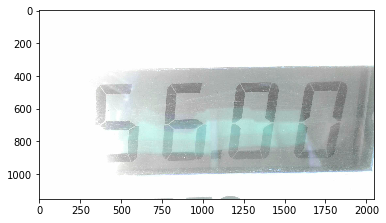

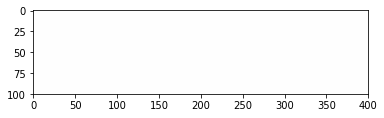

In [173]:
#image = cv2.imread('data/LQ_digital/1b4168c6e014d9588802c70e74cde6511c012454.jpg') #Image trop claire
#image = cv2.imread('data/LQ_digital/1bc770862ea5d73bfa42ea937b13dbfa52190852.jpg') #Image ne fonctionnant pas
#image = cv2.imread('data/LQ_digital/1dafcfe3396e0408ca82061eef6a43f9f732fb91.jpg') #Image trop claire
#image = cv2.imread('data/LQ_digital/1eaad91b157095fdf3b970673ca5cc2a23ca2f48.jpg') #Image trop claire
#image = cv2.imread('data/LQ_digital/1fbf0c07f81460ac53b80511fb55c06d32a3850c.jpg') # Image trop claire et floue
#image = cv2.imread('data/LQ_digital/1ff9eef553663acb92add0027644929822be7af9.jpg') # doigt sur la photo
#image = cv2.imread('data/LQ_digital/06f8b8924a15bbc86c9b0779827f6e559c4821cb.jpg') # Image sur exposée
#image = cv2.imread('data/LQ_digital/08ca689e9648f2874fc69a48006777bfb8e7992b.jpg') # Image sur exposée
image = cv2.imread('data/LQ_digital/09ae97265223b688b67803c3f471e528c9df6939.jpg') # Image sur exposée


plt.figure()
plt.imshow(image)
plt.show()
plt.imshow(preprocessing_brut(image, 0.3))

298 / 330 --> 90 %
    - 32 without any outputs
    - 2 weird ones but ok
    
303/330 --> 91.8 %
    - 28 without outputs
    - 2 weird but ok

In [108]:
303/330

0.9181818181818182